In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import re

In [2]:
# import training and testing csv files from Data folder
training_df = pd.read_csv("./Data/train.csv")
training_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [3]:
# what is the shape of training_df
training_df.shape

(8693, 14)

In [4]:
# Examine the target variable "Transported"
training_df["Transported"].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [5]:
# examine missing values and dtypes using info()
training_df.info()

# note there are missing values for almost every column except the target "Transported" and PassengerId

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<AxesSubplot:>

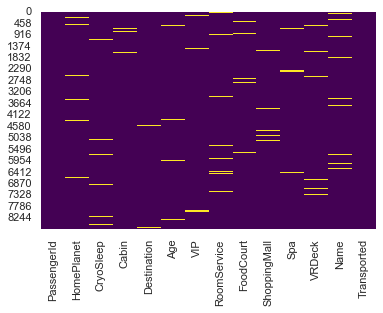

In [6]:
# visualize the missing values using seaborn heatmap
sns.heatmap(training_df.isnull(), cbar=False, cmap='viridis')

In [7]:
# use training_df[column].isnull().sum() within list comprehension
# [expression, for col in columns, where conditional is true]
col_with_missing_values = [print(col, training_df[col].isnull().sum()) for col in training_df.columns if training_df[col].isnull().sum() > 0]


HomePlanet 201
CryoSleep 217
Cabin 199
Destination 182
Age 179
VIP 203
RoomService 181
FoodCourt 183
ShoppingMall 208
Spa 183
VRDeck 188
Name 200


In [8]:
# as an inital data cleaning measure I will drop all rows with missing values to determine how much data would be lost
# clean_training_df = training_df.dropna(how='any')
# clean_training_df.info()

# will will result in the loss of over 2,000 rows

### Data Dictionary: 
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.<br>
source: https://medium.com/mlearning-ai/spaceship-titanic-an-alternative-to-the-plain-old-titanic-dataset-aa98924c606c 

In [9]:
# Extract GroupId and GroupCount from PassengerId using str.split()
# PassengerId - A unique Id for each passenger. 
# Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. 
# People in a group are often family members, but not always.
training_df[["GroupId", "GroupCount"]] = training_df["PassengerId"].str.split("_", expand=True)
training_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,GroupCount
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,01
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,01
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,01
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,01


In [10]:
# reorder columns to put PassengerId, GroupId, and GroupCount together
# training_df.columns
columns = ['PassengerId', 'GroupId', 'GroupCount', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported']
training_df = training_df[columns]
training_df

,PassengerId,GroupId,GroupCount,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,0001,01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,0002,01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,0003,01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,0003,02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,0004,01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,9276,01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,9278,01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,9279,01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,9280,01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


<AxesSubplot:>

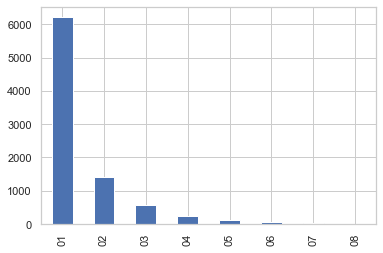

In [11]:
GroupCount = training_df["GroupCount"].value_counts()
GroupCount.plot(kind='bar')

<AxesSubplot:>

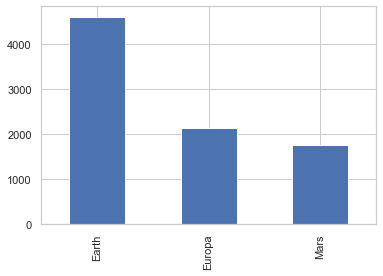

In [12]:
# Check values for HomePlanet
# HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
HomePlanet = training_df["HomePlanet"].value_counts()
HomePlanet.plot(kind='bar')

<AxesSubplot:>

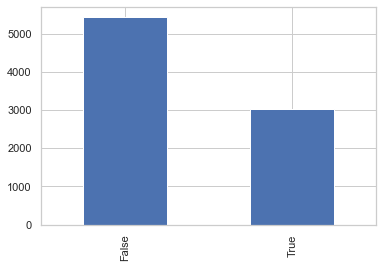

In [13]:
# Check values for CryoSleep
CryoSleep = training_df['CryoSleep'].value_counts()
CryoSleep.plot(kind='bar')

In [14]:
# # Extract deck num and side from Cabin using str.split()
# Cabin - The cabin number where the passenger is staying. 
# Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
# Check values for cabin

# make a copy 
training_df_copy = training_df.copy()
training_df_copy[["Deck", "Cabin_Number", "Side"]] = training_df_copy["Cabin"].str.split("/", expand=True)
training_df_copy

,PassengerId,GroupId,GroupCount,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_Number,Side
0,0001_01,0001,01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,0002,01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,0003,01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,0003,02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,0004,01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,9276,01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,9278,01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,9279,01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,9280,01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In [15]:
# reorder columns to put Cabin, Deck, Cabin_Number, Side together
# training_df.columns
columns = ['PassengerId', 'GroupId', 'GroupCount', 'HomePlanet', 'CryoSleep', 'Cabin', 'Deck', 'Cabin_Number', 'Side', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported']
training_df = training_df_copy[columns]
training_df

,PassengerId,GroupId,GroupCount,HomePlanet,CryoSleep,Cabin,Deck,Cabin_Number,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,0001,01,Europa,False,B/0/P,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,0002,01,Earth,False,F/0/S,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,0003,01,Europa,False,A/0/S,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,0003,02,Europa,False,A/0/S,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,0004,01,Earth,False,F/1/S,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,9276,01,Europa,False,A/98/P,A,98,P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,9278,01,Earth,True,G/1499/S,G,1499,S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,9279,01,Earth,False,G/1500/S,G,1500,S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,9280,01,Europa,False,E/608/S,E,608,S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


<AxesSubplot:>

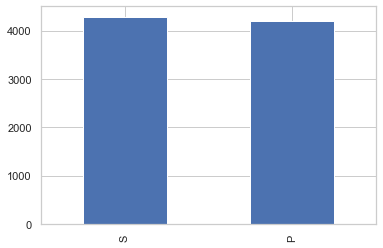

In [16]:
# Side counts
Side = training_df['Side'].value_counts()
Side.plot(kind='bar')

In [17]:
# Destination value counts
Destination = training_df["Destination"].value_counts()
Destination

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

<AxesSubplot:>

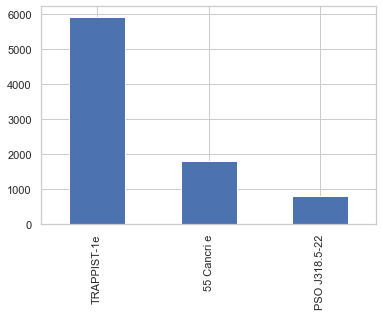

In [18]:
Destination.plot(kind='bar')

<AxesSubplot:>

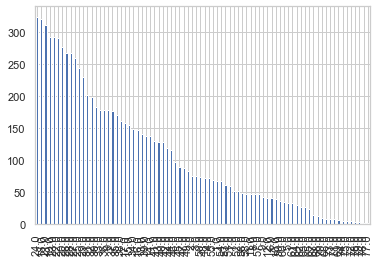

In [19]:
Age = training_df['Age']
Age.value_counts().plot(kind='bar')

In [20]:
# first examine the distribution of age
Age.describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

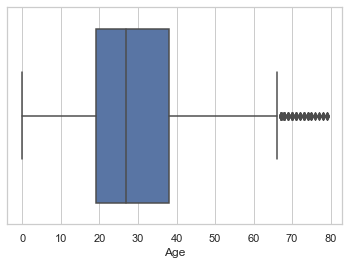

In [21]:
# visualize the distribution of age in a box plot
ax = sns.boxplot(x=Age)

In [22]:
# age needs to be binned
# make a copy
training_df_copy = training_df.copy()

age_bins = [0, 9, 19, 29, 39, 49, 59, 69, 79]

training_df_copy['Age_bins'] = pd.cut(x=training_df_copy['Age'], bins=age_bins)
training_df = training_df_copy
training_df

,PassengerId,GroupId,GroupCount,HomePlanet,CryoSleep,Cabin,Deck,Cabin_Number,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_bins
0,0001_01,0001,01,Europa,False,B/0/P,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,"(29, 39]"
1,0002_01,0002,01,Earth,False,F/0/S,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,"(19, 29]"
2,0003_01,0003,01,Europa,False,A/0/S,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,"(49, 59]"
3,0003_02,0003,02,Europa,False,A/0/S,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,"(29, 39]"
4,0004_01,0004,01,Earth,False,F/1/S,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,"(9, 19]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,9276,01,Europa,False,A/98/P,A,98,P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,"(39, 49]"
8689,9278_01,9278,01,Earth,True,G/1499/S,G,1499,S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,"(9, 19]"
8690,9279_01,9279,01,Earth,False,G/1500/S,G,1500,S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,"(19, 29]"
8691,9280_01,9280,01,Europa,False,E/608/S,E,608,S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,"(29, 39]"


<AxesSubplot:>

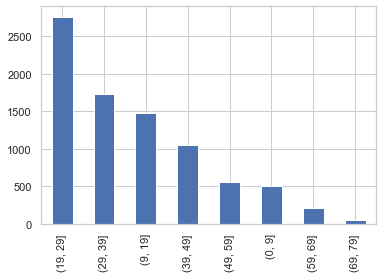

In [23]:
# view age bins
Age_bins = training_df['Age_bins']
Age_bins.value_counts().plot(kind='bar')

In [24]:
str.split()

TypeError: descriptor 'split' of 'str' object needs an argument

In [ ]:
# split out first and last names
training_df[['First_Name', 'Last_Name']] = training_df['Name'].str.split(expand=True)
training_df

In [ ]:
# review missing values
training_df.info()

In [ ]:
# visualize the missing values using seaborn heatmap
sns.heatmap(training_df.isnull(), cbar=False, cmap='viridis')

In [ ]:
# drop "duplicate" columns
training_df.columns

In [ ]:
training_df.drop(columns=['PassengerId', 'Cabin', 'Age','Name'], inplace=True)
training_df

In [ ]:
# examine dtypes
training_df.dtypes